# --- CHECK COMPLETE ---

# Ajustes iniciales

## Conexión a drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd ./drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
%pwd

'/content/drive/MyDrive/Colab Notebooks'

## Importar los módulos *_utils

In [4]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from my_utils import dataset_utils
from my_utils import eval_utils
from my_utils import nn_utils
from my_utils import results_utils

In [5]:
import pickle

# Funciones locales

## Prototipos de modelo

The requirements to use the cuDNN implementation are:

1. activation == tanh
2. recurrent_activation == sigmoid
3. recurrent_dropout == 0
4. unroll is False
5. use_bias is True
6. Inputs, if use masking, are strictly right-padded.
7. Eager execution is enabled in the outermost context.

Check: KERAS docs [https://keras.io/api/layers/recurrent_layers/lstm/]



### RecurrentLSTM

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

def recurrentLSTM_NetModel(task, params, optimizer, verbose = False):
  """
  Defines and compiles a new Keras model for a Convolutional Neural Network

  """

  SEQ_LENGTH = 55
  VEC_EMBEDDINGS_DIM = 300

  units_lstm = params['units_lstm']
  merge_mode = params['merge_mode']

  n_filters  = params['n_filters']
  kernel_size_1, kernel_size_2, kernel_size_3 = params['kernels_sizes']
  conv_activation = params['conv_activation'] 
  units_DL1, units_DL2 = params['dense_layers_sizes']

  lstm_dropout  = params['lstm_dropout']
  spatial_dropout = params['spatial_dropout']
  dense_dropout = params['dense_dropout']

  embedding_sequence_input = keras.Input(name='INPUT',
                                          shape=(SEQ_LENGTH, VEC_EMBEDDINGS_DIM), 
                                          dtype="float64")
  
  LSTM_layer    = layers.LSTM(units=units_lstm, dropout=lstm_dropout, recurrent_dropout=0, return_sequences=True, name='LSTM')
  BiLSTM_layer  = layers.Bidirectional(LSTM_layer, merge_mode, name='BI-LSTM')

  lstm_out = BiLSTM_layer(embedding_sequence_input)

  cnn_1 = layers.Conv1D(n_filters, kernel_size_1, activation=conv_activation, name = 'CNN_1')(lstm_out)
  cnn_1 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_1')(cnn_1)

  cnn_2 = layers.Conv1D(n_filters, kernel_size_2, activation=conv_activation, name = 'CNN_2')(lstm_out)
  cnn_2 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_2')(cnn_2)

  cnn_3 = layers.Conv1D(n_filters, kernel_size_3, activation=conv_activation, name = 'CNN_3')(lstm_out)
  cnn_3 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_3')(cnn_3)


  if params['pooling_method'] == 'max':
    pool_1 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_1')(cnn_1)
    pool_2 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_2')(cnn_2)
    pool_3 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_3')(cnn_3)
  elif params['pooling_method'] == 'average':
    pool_1 = layers.GlobalAveragePooling1D(name = 'AVG_POOL_1')(cnn_1)
    pool_2 = layers.GlobalAveragePooling1D(name = 'AVG_POOL_2')(cnn_2)
    pool_3 = layers.GlobalAveragePooling1D(name = 'AVG_POOL_3')(cnn_3)

  fcnn_input = layers.Concatenate(axis=1, name = 'CONCATENATE')([pool_1, pool_2, pool_3])
  fc_layer_1 = layers.Dense(units_DL1, activation="relu", name = 'DL_1')(fcnn_input)
  fc_layer_1 = layers.Dropout(dense_dropout, name = 'DROP_1')(fc_layer_1)
  fc_layer_2 = layers.Dense(units_DL2, activation="relu", name = 'DL_2')(fc_layer_1)
  fc_layer_2 = layers.Dropout(dense_dropout, name = 'DROP_2')(fc_layer_2)

  if task in ['HS', 'TR', 'AG']:
    preds = layers.Dense(1, activation="sigmoid", name = 'PREDICTOR')(fc_layer_2)
    model = keras.Model(embedding_sequence_input, preds)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

  elif task == 'HTA':
    preds = layers.Dense(5, activation="softmax", name = 'PREDICTOR')(fc_layer_2)
    preds = reshape = layers.Reshape(target_shape=(5,))(preds)

    model = keras.Model(embedding_sequence_input, preds)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])

  if verbose:
    model.summary()

  return model

## Dataset

In [7]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['AG'],
                                                 n_folds=7)

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


# Bloque 1 (optimizers)

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(300,100),
                      (200,100)]  

arch_params = {'units_lstm':[200],
          'merge_mode':['concat'],
          'n_filters':[150],
          'kernels_sizes':[(1,2,3),(2,3,4)],
          'dense_layers_sizes': dense_layers_sizes,
          'conv_activation':['tanh'],
          'pooling_method':['max'],
          'spatial_dropout':[0.5],
          'lstm_dropout':[0.5],
          'dense_dropout':[0.3]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

4 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4'],
                       'batch_size':[256,512,1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


18 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


72 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          recurrentLSTM_NetModel, 
                          search_space[40:],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/ConvLSTM/AG/experiments_1_3.df',
                          backup_freq=1,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
import pickle
with open('./Results/ConvLSTM/AG/experiments_1.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(72, 22)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

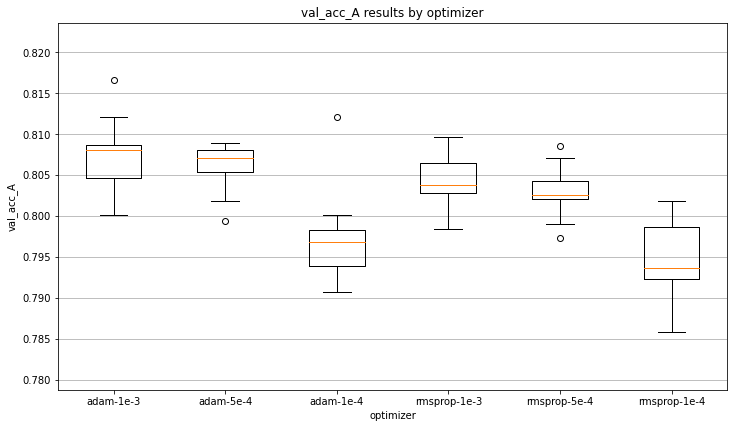

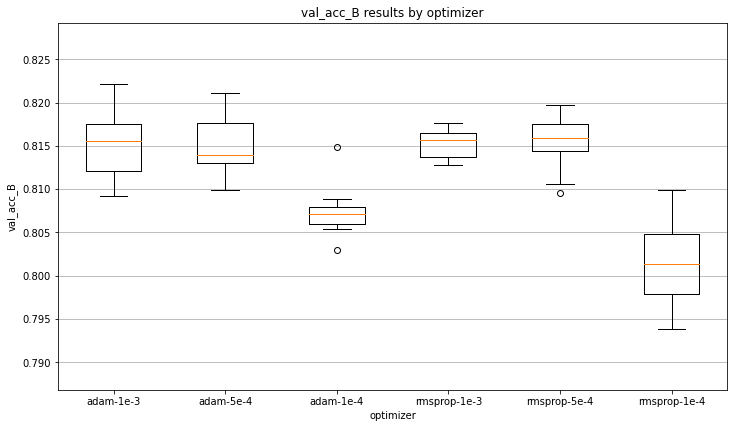

In [ ]:
params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 
                            'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4']                                
}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_B')

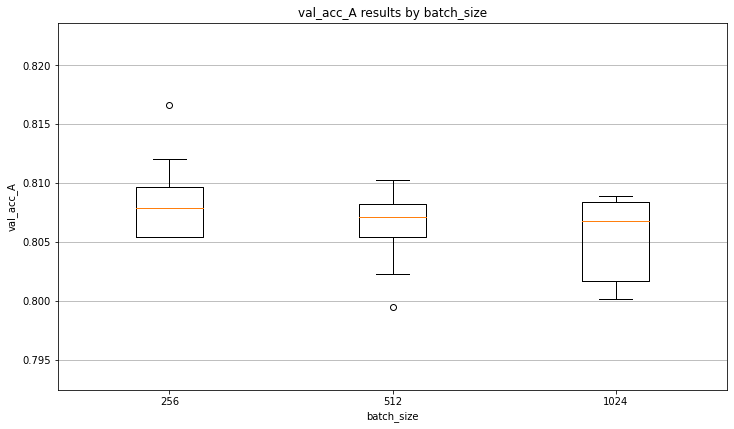

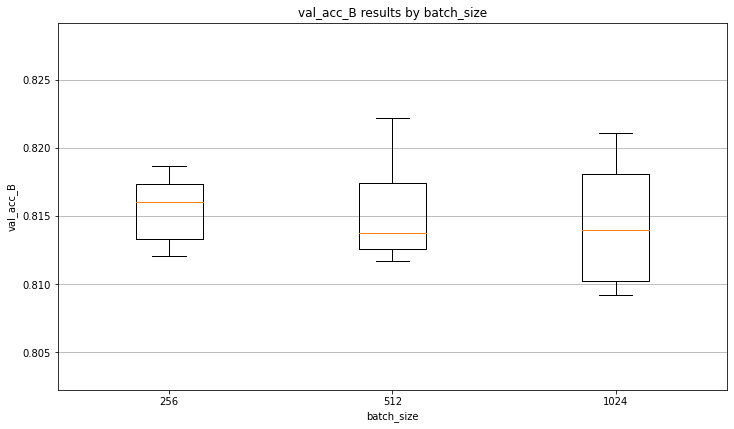

In [ ]:
params_dict = {'batch_size':[256,512,1024]                                
}

optimizer_mask = results_df.optimizer.isin(['adam-1e-3', 'adam-5e-4'])

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df.loc[optimizer_mask], 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_B')

### Resumen de los resultados

* optimizador: [**'adam-1e-3'**,'adam-5e-4']

# Bloque 2 (**lstm_units**, kernels_sizes, batch_size)

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(300,100),
                      (200,100)]  

arch_params = {'units_lstm':[150,200,250],
          'merge_mode':['concat'],
          'n_filters':[150],
          'kernels_sizes':[(1,2,3),(2,3,4)],
          'dense_layers_sizes': dense_layers_sizes,
          'conv_activation':['tanh'],
          'pooling_method':['max'],
          'spatial_dropout':[0.5],
          'lstm_dropout':[0.5],
          'dense_dropout':[0.3]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))  

12 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3','adam-5e-4'],
                       'batch_size':[256,512],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


4 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


48 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          recurrentLSTM_NetModel, 
                          search_space[38:],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/ConvLSTM/AG/experiments_2_3.df',
                          backup_freq=1,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
import pickle
with open('./Results/ConvLSTM/AG/experiments_2.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(47, 22)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


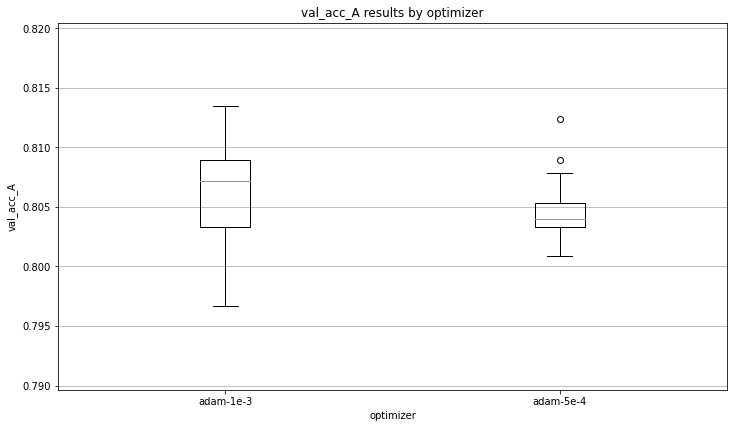

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


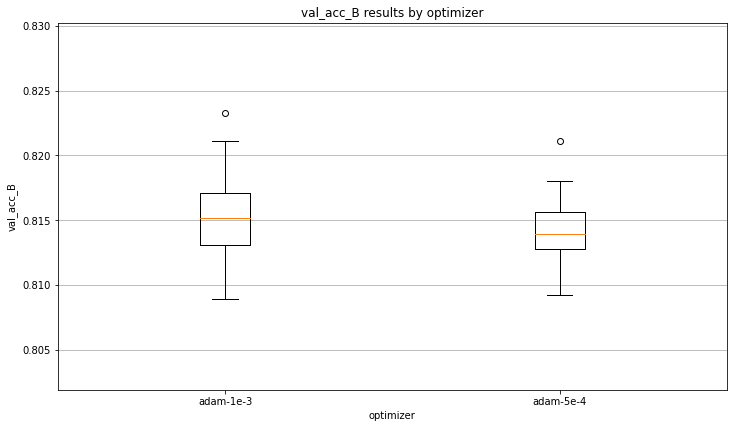

In [ ]:
params_dict = {'optimizer':['adam-1e-3','adam-5e-4']}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_B')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


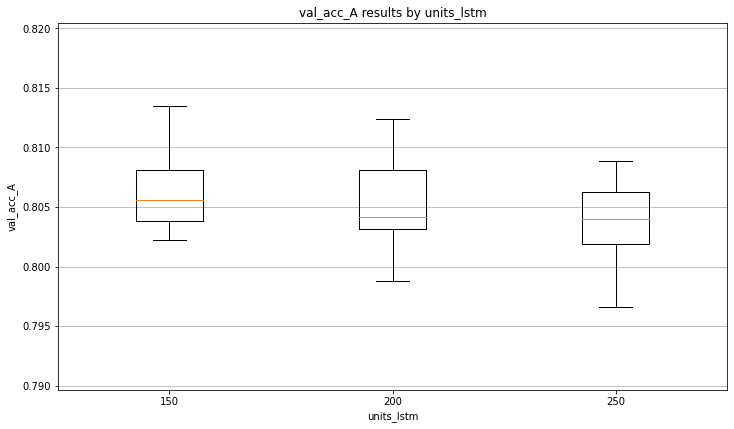

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


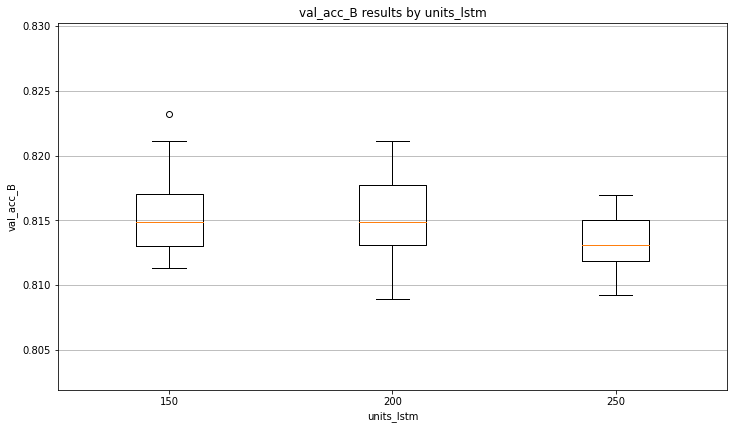

In [ ]:
params_dict = {'units_lstm':[150,200,250]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['units_lstm'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['units_lstm'],
                       metric='val_acc_B')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


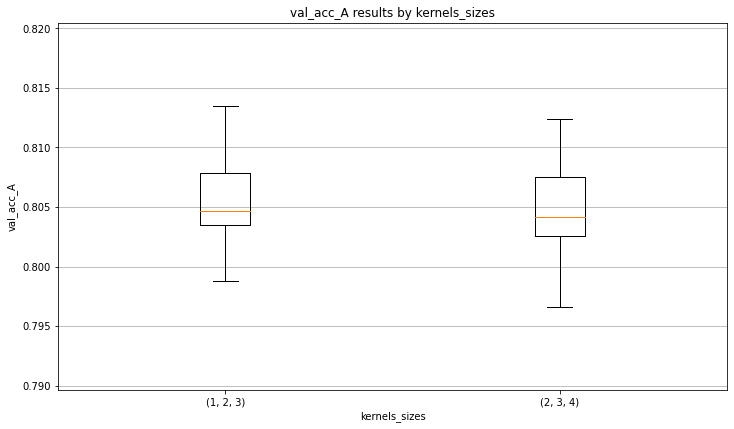

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


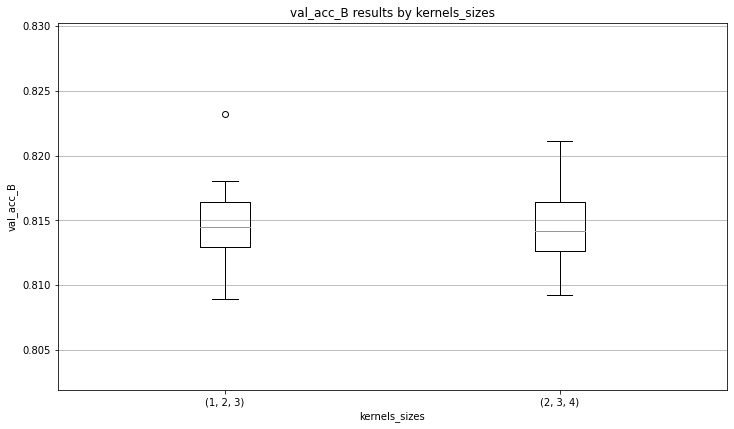

In [ ]:
params_dict = {'kernels_sizes':[(1,2,3),(2,3,4)]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['kernels_sizes'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['kernels_sizes'],
                       metric='val_acc_B')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


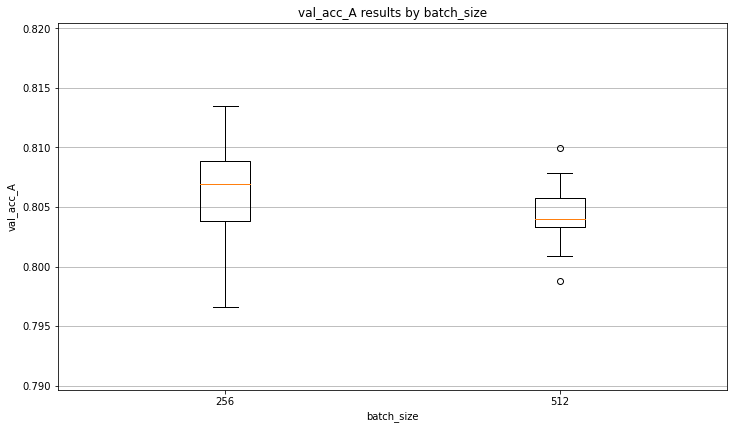

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


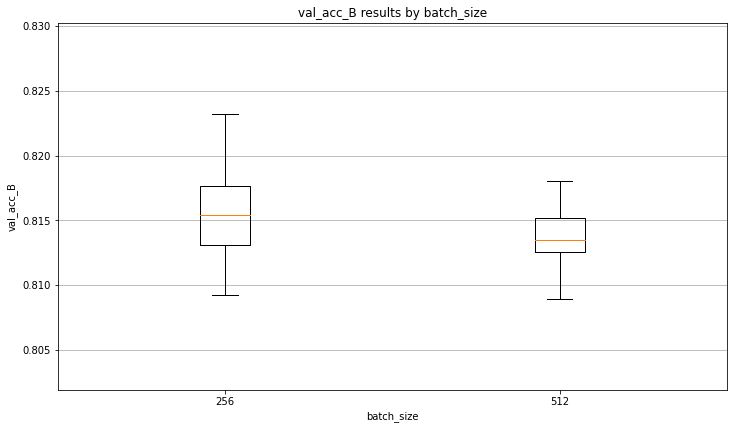

In [ ]:
params_dict = {'batch_size':[256,512]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_B')

### Resumen de los resultados

* LSTM-units: [-150-,200]
* kernels_sizes: [-(1,2,3)-, (2,3,4)]

* batch_size: [**256**]
* optimizador: [**'adam-1e-3'**,'adam-5e-4']

# Bloque 3 (n_filters, cnn_activ)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(300,100),
                      (300,75),
                      (200,100),
                      (200,75)]  

arch_params = {'units_lstm':[150],
          'merge_mode':['concat'],
          'n_filters':[100,150,200],
          'kernels_sizes':[(1,2,3)],
          'dense_layers_sizes': dense_layers_sizes,
          'conv_activation':['tanh','relu'],
          'pooling_method':['max'],
          'spatial_dropout':[0.5],
          'lstm_dropout':[0.5],
          'dense_dropout':[0.3]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))  

24 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3','adam-5e-4'],
                       'batch_size':[256],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


48 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          recurrentLSTM_NetModel, 
                          search_space[24:],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/ConvLSTM/AG/experiments_3_2.df',
                          backup_freq=1,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
import pickle
with open('./Results/ConvLSTM/AG/experiments_3.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(48, 22)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

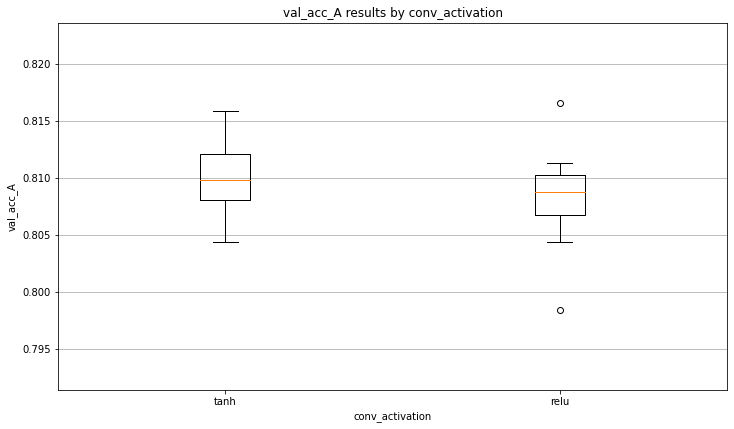

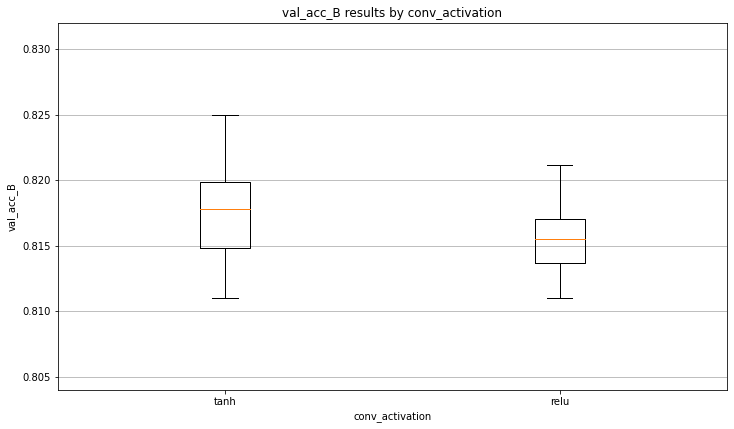

In [ ]:
params_dict = {'conv_activation':['tanh','relu']}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['conv_activation'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['conv_activation'],
                       metric='val_acc_B')

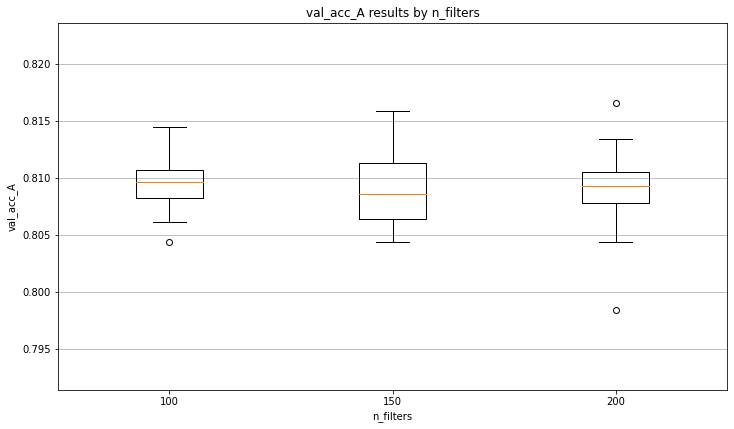

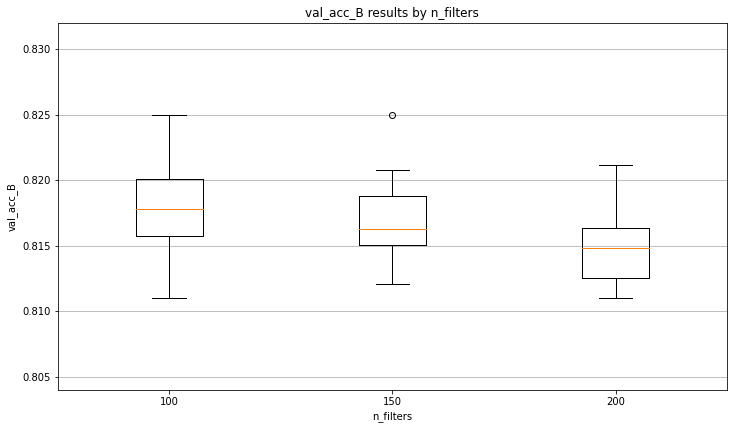

In [ ]:
params_dict = {'n_filters':[100,150,200]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_B')

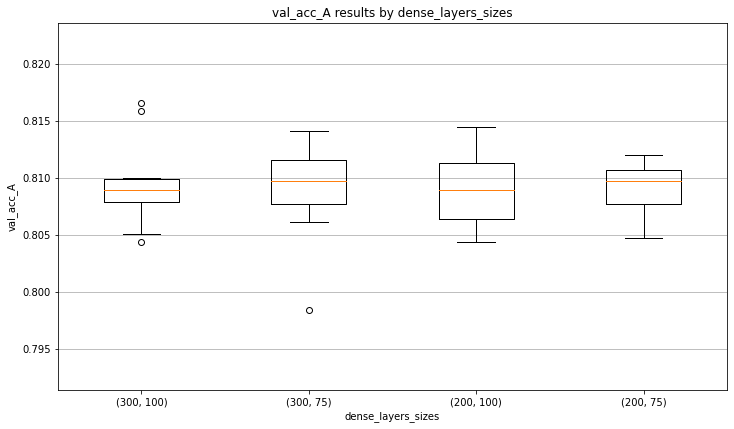

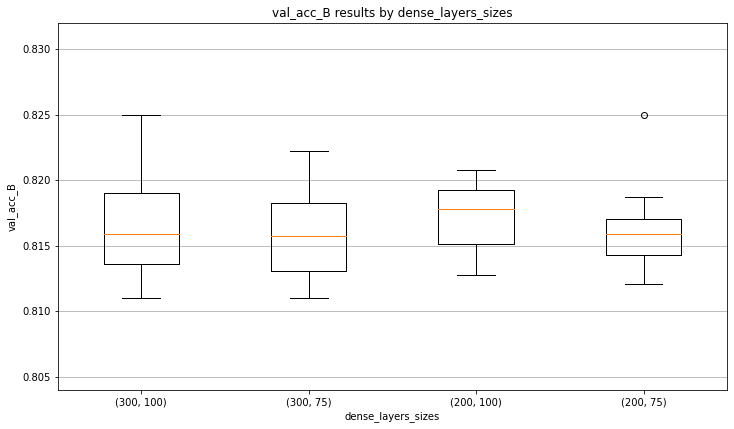

In [ ]:
params_dict = {'dense_layers_sizes':[(300,100),
                      (300,75),
                      (200,100),
                      (200,75)]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['dense_layers_sizes'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['dense_layers_sizes'],
                       metric='val_acc_B') 

### Resumen de los resultados

* LSTM-units: [-150-, 200]
* kernels_sizes: [-(1,2,3)-, (2,3,4)]
* n_filters: [**100**, 150]
* conv_activ: ['tanh']
* dese-layers: [(300,100), **(300,75)**, **(200,100)**]

* batch_size: [**256**]
* optimizador: [**'adam-1e-3'**,'adam-5e-4']

# Bloque 4 (dropout)

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

dense_layers_sizes = [(300,75),
                      (200,100)]  

arch_params = {'units_lstm':[150],
          'merge_mode':['concat'],
          'n_filters':[100],
          'kernels_sizes':[(1,2,3)],
          'dense_layers_sizes': dense_layers_sizes,
          'conv_activation':['tanh'],
          'pooling_method':['max'],
          'spatial_dropout':[0.3,0.5,0.7],
          'lstm_dropout':[0.3,0.5,0.7],
          'dense_dropout':[0.3,0.5,0.7]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))  

18 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3'],
                       'batch_size':[256],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


1 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


18 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          recurrentLSTM_NetModel, 
                          search_space[:9],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/ConvLSTM/AG/experiments_4.df',
                          backup_freq=1,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [6]:
import pickle
from pandas import DataFrame

with open('./Results/ConvLSTM/AG/experiments_4.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(54, 22)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head(36)

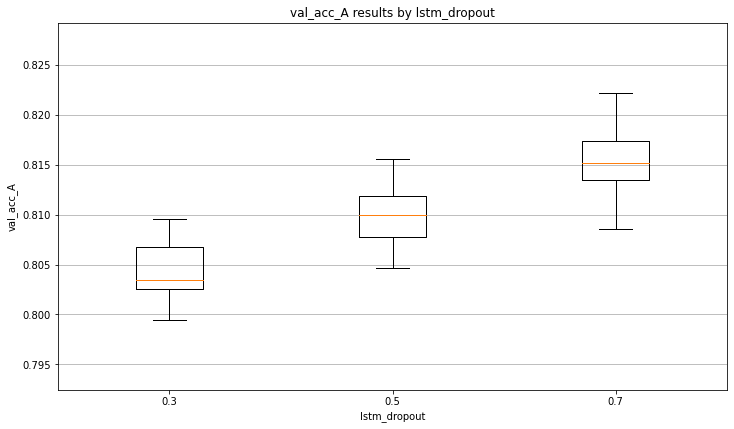

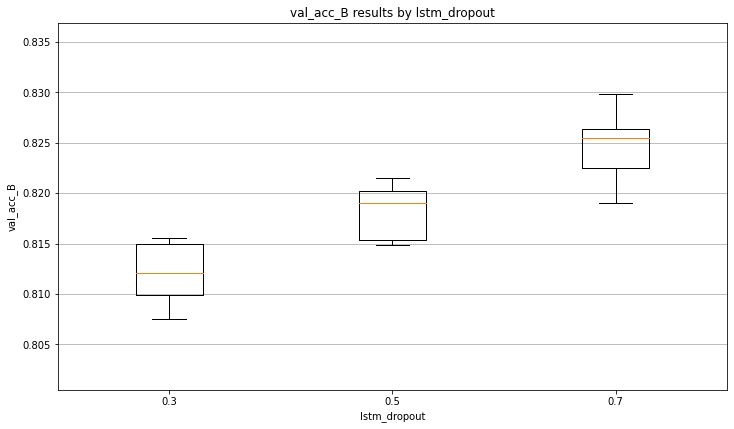

In [ ]:
params_dict = {'lstm_dropout':[0.3,0.5,0.7]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['lstm_dropout'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['lstm_dropout'],
                       metric='val_acc_B')

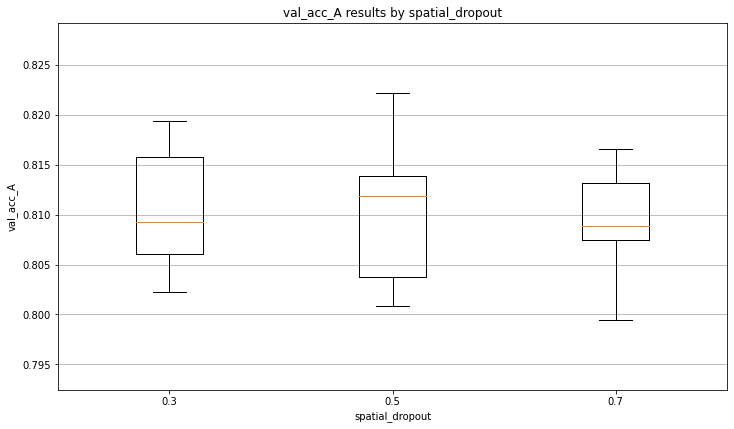

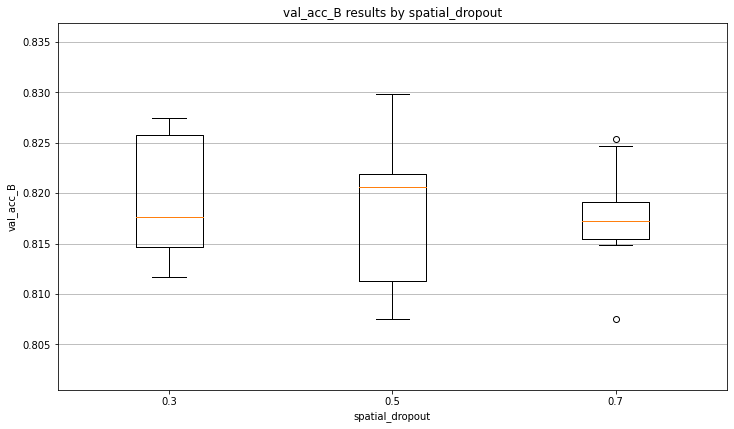

In [ ]:
params_dict = {'spatial_dropout':[0.3,0.5,0.7]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['spatial_dropout'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['spatial_dropout'],
                       metric='val_acc_B')

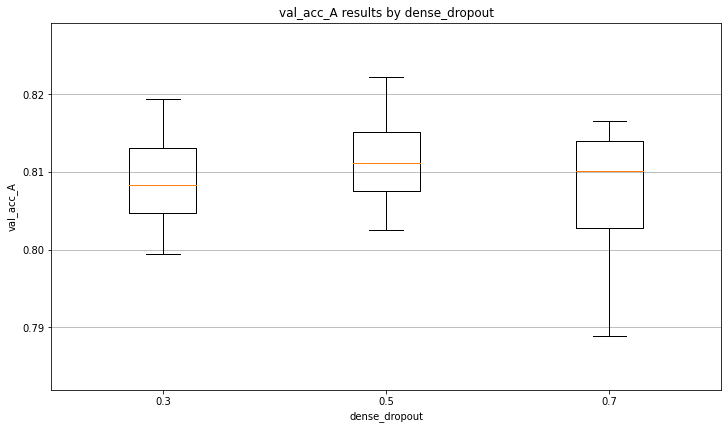

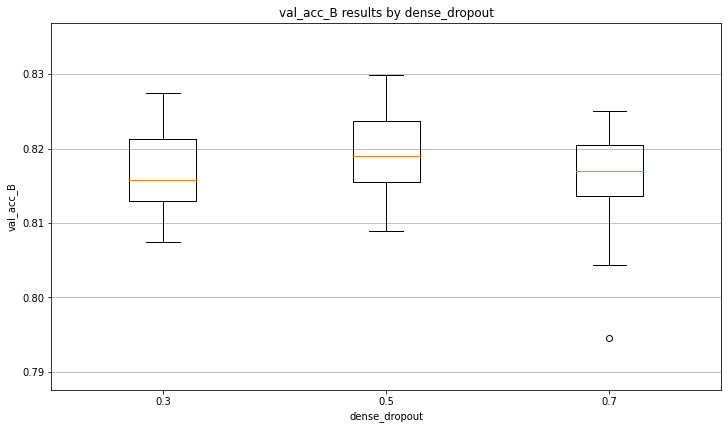

In [ ]:
params_dict = {'dense_dropout':[0.3,0.5,0.7]}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['dense_dropout'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['dense_dropout'],
                       metric='val_acc_B')

### Resumen de los resultados (checked)

* LSTM-units: [-150-, 200]
* kernels_sizes: [-(1,2,3)-, (2,3,4)]
* n_filters: [**100**, 150]
* conv_activ: ['tanh']
* dese-layers: [(300,100), **(300,75)**, **(200,100)**]
* lstm_dropout: [0.7]
* spatial_dropout: [0.5]
* dense_dropout: [0.5]

* batch_size: [**256**]
* optimizador: [**'adam-1e-3'**]

# Bloque 5 (validacion completa)

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [8]:
from itertools import product

dense_layers_sizes = [(300,75),
                      (200,100)]  

arch_params = {'units_lstm':[150,200],
          'merge_mode':['concat'],
          'n_filters':[100,150],
          'kernels_sizes':[(1,2,3),(2,3,4)],
          'dense_layers_sizes': dense_layers_sizes,
          'conv_activation':['relu'],
          'pooling_method':['max'],
          'spatial_dropout':[0.7],
          'lstm_dropout':[0.5],
          'dense_dropout':[0.5]}

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))  

16 arch_params_combos.


**Parámetros de la arquitectura**

In [9]:
trainig_params_dict = {'optimizer':['adam-1e-3'],
                       'batch_size':[256],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


1 trainig_params_combos.


In [10]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


16 params combinations in the search_space.


## Escaneo

In [14]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          recurrentLSTM_NetModel, 
                          search_space[:16],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=False,
                          backup_file='./Results/ConvLSTM/AG/experiments_5_1.df',
                          backup_freq=1,
                          save_history_files=True,
                          save_models_as_json=True,
                          save_weights=True
                          )

BackupFile: ./Results/ConvLSTM/AG/experiments_5_1.df
SCANNING SEARCH SPACE

16 configurations will be evaluated.
1  - conf_ID: gcVkhcdU   *******  --  train_acc_1 = 0.81,   val_acc_1 = 0.819    --  train_acc_2 = 0.803,  val_acc_2 = 0.828   
2  - conf_ID: xLKkQHkm   *******  --  train_acc_1 = 0.807,  val_acc_1 = 0.816    --  train_acc_2 = 0.821,  val_acc_2 = 0.823   
3  - conf_ID: eTTyKeyx   *******  --  train_acc_1 = 0.806,  val_acc_1 = 0.812    --  train_acc_2 = 0.813,  val_acc_2 = 0.824   
4  - conf_ID: PiKgmstT   *******  --  train_acc_1 = 0.791,  val_acc_1 = 0.818    --  train_acc_2 = 0.8,    val_acc_2 = 0.824   
5  - conf_ID: hgRvRlbQ   *******  --  train_acc_1 = 0.792,  val_acc_1 = 0.814    --  train_acc_2 = 0.798,  val_acc_2 = 0.823   
6  - conf_ID: XGYrXoWQ   *******  --  train_acc_1 = 0.795,  val_acc_1 = 0.816    --  train_acc_2 = 0.802,  val_acc_2 = 0.827   
7  - conf_ID: XHyEtTrF   *******  --  train_acc_1 = 0.824,  val_acc_1 = 0.814    --  train_acc_2 = 0.8,    val_acc_2 = 

## Resultados

In [ ]:
results_list = ['./Results/ConvLSTM/AG/experiments_5f_1.df',
                './Results/ConvLSTM/AG/experiments_5f_2.df']

results_df = results_utils.mergeDataFrames(results_list, './Results/ConvLSTM/AG/experiments_5f.df')

In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/ConvLSTM/AG/experiments_5f.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(16, 22)